# CIFAR-10 с трюками

В этом задании мы продолжим работать с CIFAR-10, опробовав трюки, про которые мы узнали в 4 модуле.

Датасет CIFAR-10 состоит из цветных картинок 32x32, разделенных на 10 классов: 

__airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck__

# Импорты

In [1]:
!pip install -q tensorflow==2.1

ERROR: Could not find a version that satisfies the requirement tensorflow==2.1 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.13.0rc0)
ERROR: No matching distribution found for tensorflow==2.1


In [2]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.models as M
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
print(tf.__version__)
print(keras.__version__)

2.12.0
2.12.0


# Загружаем данные

In [3]:
from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 2s 0us/step


In [4]:
print("Трейн:", x_train.shape, y_train.shape)
print("Тест:", x_test.shape, y_test.shape)

Трейн: (50000, 32, 32, 3) (50000, 1)
Тест: (10000, 32, 32, 3) (10000, 1)


In [5]:
NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", 
                   "dog", "frog", "horse", "ship", "truck"]

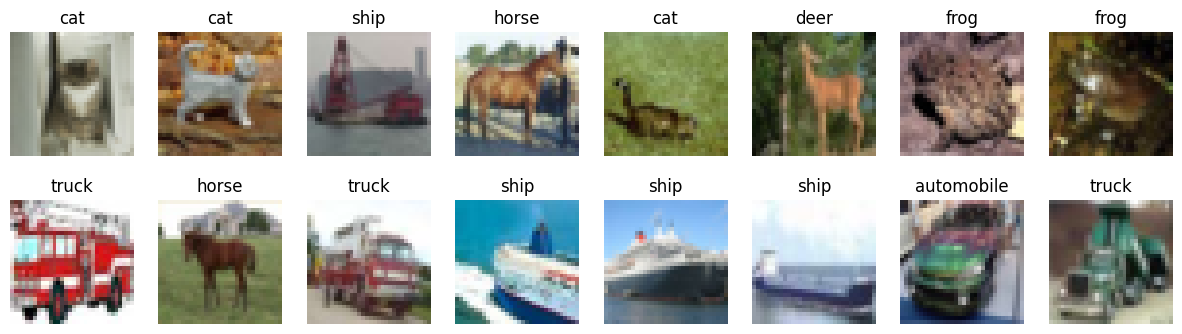

In [6]:
# посмотрим на примеры картинок
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_train[random_index, :])
        ax.set_title(cifar10_classes[y_train[random_index, 0]])
plt.show()

# Готовим данные

Не забудьте нормализовать картинки: $$x_{norm} = \frac{x}{255} - 0.5$$

А еще нужно превратить метки в one-hot вектора при помощи __keras.utils.to_categorical__.

In [7]:
# нормализуем входы
x_train2 = x_train.astype('float32') / 255 - 0.5
x_test2 = x_test.astype('float32') / 255 - 0.5

# конвертируем метки в np.array (?, NUM_CLASSES)
y_train2 = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test2 = keras.utils.to_categorical(y_test, NUM_CLASSES)

# Задаем *дефолтную* архитектуру сети

In [8]:
# слои, которые нам пригодятся
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

Нам понадобятся такие слои:
- [Conv2D](https://keras.io/layers/convolutional/#conv2d) - сверточный слой:
    - **filters**: количество фильтров на выходе; 
    - **kernel_size**: размер скользящего окна;
    - **padding**: padding="same" добивает нулями, чтобы ширина и высота на выходе не изменились, padding='valid' берет только окна, которые полностью помещаются в картинке;
    - **activation**: "relu", "tanh", итд;
    - **input_shape**: размер входа вида (W, H, C_in).
- [MaxPooling2D](https://keras.io/layers/pooling/#maxpooling2d) - пулинг
- [Flatten](https://keras.io/layers/core/#flatten) - все оси, кроме батча (первой) вытягиваются в один вектор.
- [Dense](https://keras.io/layers/core/#dense) - плотный, активацию можно задать через activation="elu" или activation="softmax".
- [Dropout](https://keras.io/layers/core/#dropout) - дропаут регуляризация (без нее сеть сильно переобучается), позже узнаем какой у нее смысл.

Ваша модель должна принимать на вход цветную картинку __(None, 32, 32, 3)__ и предсказывать вероятности 10 классов __(None, 10)__.

Добавьте __4__ сверточных слоя с окном __(3, 3)__ с нарастающим количеством фильтров: __(16, 32, 32, 64)__, используйте "same" паддинг.

Добавьте __2x2__ макс пулинг после каждых 2 сверточных слоев (conv-conv-pool схема).

Используйте __activation='relu'__ для всех слоев, где это нужно.

Добавьте плотный слой из __256__ нейронов и еще один из __10__ нейронов для предсказания выходов. Не забудьте применить __Flatten__ перед первым плотным слоем!

Для регуляризации сети вставьте Dropout после каждого пулинг слоя (с параметром** 0.25**) и между плотными слоями на выходе (с параметром **0.5**).

В дальнейшем будем называть эту архитектуру **дефолтной** и будем исследовать небольшие изменения в ней!

In [9]:
def make_default_model():
    model = Sequential()
    model.add(
        Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation="relu", input_shape=(32, 32, 3))
    )
    model.add(
        Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation="relu")
    )
    model.add(
        MaxPooling2D(pool_size=(2, 2))
    )
    model.add(
        Dropout(rate=0.25)
    )
    model.add(
        Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation="relu")
    )
    model.add(
        Conv2D(filters=54, kernel_size=(3, 3), padding='same', activation="relu")
    )
    model.add(
        MaxPooling2D(pool_size=(2, 2))
    )
    model.add(
        Dropout(rate=0.25)
    )
    model.add(
        Flatten()
    )
    model.add(
        Dense(units=256, activation='relu')
    )
    model.add(
        Dropout(rate=0.5)
    )
    model.add(
        Dense(units=10, activation='softmax')
    )
    return model

In [10]:
K.clear_session()
model = make_default_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 16)        448       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 32)        9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 54)        15606     
                                                        

# Тренируем модель

In [11]:
def train_model(make_model_func=make_default_model, optimizer="adam"):
  BATCH_SIZE = 32
  EPOCHS = 10

  K.clear_session()
  model = make_model_func()

  model.compile(
      loss='categorical_crossentropy',
      optimizer=optimizer,
      metrics=['accuracy']
  )

  model.fit(
      x_train2, y_train2,  # нормализованные данные
      batch_size=BATCH_SIZE,
      epochs=EPOCHS,
      validation_data=(x_test2, y_test2),
      shuffle=False
  )
  
  return model

Давайте посмотрим, что будет с дефолтной моделью (модель = make_default_model, оптимайзер = "adam"), если ее немного поменять:


Часть 1 :
1.   Какое качество (accuracy) на валидации дает **дефолтная архитектура**?

Часть 2:
2.   Измените в дефолтной архитектуре **relu активацию на sigmoid**, какое качество на валидации получили?
3.   Измените в дефолтной архитектуре **adam оптимайзер на sgd**, какое качество на валидации получили?
4.   Добавьте к дефолтной архитектуре **батч нормализацию** после каждого сверточного слоя и после перового полносвязного (model.add(BatchNormalization())), какое качество на валидации получили?
5.   Добавьте к дефолтной архитектуре **батч нормализацию** и смените **relu активацию на sigmoid**,  какое качество на валидации получили?
  
*Рекомендуется завести свою функцию для каждого изменения архитектуры!*


In [12]:
# учим дефолтную архитектуру
train_model()

Epoch 1/10
1563/1563 [==============================] - 25s 7ms/step - loss: 1.4965 - accuracy: 0.4579 - val_loss: 1.0723 - val_accuracy: 0.6199
Epoch 2/10
1563/1563 [==============================] - 11s 7ms/step - loss: 1.1132 - accuracy: 0.6060 - val_loss: 0.9246 - val_accuracy: 0.6745
Epoch 3/10
1563/1563 [==============================] - 11s 7ms/step - loss: 0.9726 - accuracy: 0.6587 - val_loss: 0.8243 - val_accuracy: 0.7131
Epoch 4/10
1563/1563 [==============================] - 11s 7ms/step - loss: 0.8754 - accuracy: 0.6903 - val_loss: 0.7825 - val_accuracy: 0.7287
Epoch 5/10
1563/1563 [==============================] - 10s 7ms/step - loss: 0.8155 - accuracy: 0.7119 - val_loss: 0.7602 - val_accuracy: 0.7322
Epoch 6/10
1563/1563 [==============================] - 10s 7ms/step - loss: 0.7713 - accuracy: 0.7289 - val_loss: 0.7550 - val_accuracy: 0.7411
Epoch 7/10
1563/1563 [==============================] - 10s 6ms/step - loss: 0.7319 - accuracy: 0.7431 - val_loss: 0.7331 - val_ac

In [13]:
def make_sigmoid_model():
    model = Sequential()
    model.add(
        Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation="sigmoid", input_shape=(32, 32, 3))
    )
    model.add(
        Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation="sigmoid")
    )
    model.add(
        MaxPooling2D(pool_size=(2, 2))
    )
    model.add(
        Dropout(rate=0.25)
    )
    model.add(
        Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation="sigmoid")
    )
    model.add(
        Conv2D(filters=54, kernel_size=(3, 3), padding='same', activation="sigmoid")
    )
    model.add(
        MaxPooling2D(pool_size=(2, 2))
    )
    model.add(
        Dropout(rate=0.25)
    )
    model.add(
        Flatten()
    )
    model.add(
        Dense(units=256, activation='sigmoid')
    )
    model.add(
        Dropout(rate=0.5)
    )
    model.add(
        Dense(units=10, activation='softmax')
    )
    return model

In [14]:
# учим sigmoid
train_model(make_sigmoid_model)

Epoch 1/10
1563/1563 [==============================] - 14s 7ms/step - loss: 2.3174 - accuracy: 0.0969 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 2/10
1563/1563 [==============================] - 11s 7ms/step - loss: 2.3033 - accuracy: 0.0965 - val_loss: 2.3027 - val_accuracy: 0.1000
Epoch 3/10
1563/1563 [==============================] - 10s 6ms/step - loss: 2.3036 - accuracy: 0.0983 - val_loss: 2.3029 - val_accuracy: 0.1000
Epoch 4/10
1563/1563 [==============================] - 11s 7ms/step - loss: 2.3034 - accuracy: 0.0978 - val_loss: 2.3028 - val_accuracy: 0.1000
Epoch 5/10
1563/1563 [==============================] - 11s 7ms/step - loss: 2.3033 - accuracy: 0.0982 - val_loss: 2.3035 - val_accuracy: 0.1000
Epoch 6/10
1563/1563 [==============================] - 11s 7ms/step - loss: 2.3036 - accuracy: 0.0990 - val_loss: 2.3028 - val_accuracy: 0.1000
Epoch 7/10
1563/1563 [==============================] - 10s 7ms/step - loss: 2.3034 - accuracy: 0.0998 - val_loss: 2.3030 - val_ac

In [15]:
# учим sgd
train_model(optimizer="sgd")

Epoch 1/10
1563/1563 [==============================] - 13s 7ms/step - loss: 2.0828 - accuracy: 0.2361 - val_loss: 1.7616 - val_accuracy: 0.3780
Epoch 2/10
1563/1563 [==============================] - 10s 6ms/step - loss: 1.7043 - accuracy: 0.3777 - val_loss: 1.5121 - val_accuracy: 0.4584
Epoch 3/10
1563/1563 [==============================] - 10s 6ms/step - loss: 1.5407 - accuracy: 0.4365 - val_loss: 1.3736 - val_accuracy: 0.4975
Epoch 4/10
1563/1563 [==============================] - 10s 6ms/step - loss: 1.4246 - accuracy: 0.4834 - val_loss: 1.3050 - val_accuracy: 0.5323
Epoch 5/10
1563/1563 [==============================] - 10s 6ms/step - loss: 1.3331 - accuracy: 0.5188 - val_loss: 1.2085 - val_accuracy: 0.5618
Epoch 6/10
1563/1563 [==============================] - 10s 6ms/step - loss: 1.2606 - accuracy: 0.5466 - val_loss: 1.1271 - val_accuracy: 0.6051
Epoch 7/10
1563/1563 [==============================] - 9s 6ms/step - loss: 1.1970 - accuracy: 0.5710 - val_loss: 1.1099 - val_acc

In [16]:
def make_bn_model():
    model = Sequential()
    model.add(
        Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation="relu", input_shape=(32, 32, 3))
    )
    model.add(L.BatchNormalization())
    model.add(
        Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation="relu")
    )
    model.add(L.BatchNormalization())
    model.add(
        MaxPooling2D(pool_size=(2, 2))
    )
    model.add(
        Dropout(rate=0.25)
    )
    model.add(
        Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation="relu")
    )
    model.add(L.BatchNormalization())
    model.add(
        Conv2D(filters=54, kernel_size=(3, 3), padding='same', activation="relu")
    )
    model.add(L.BatchNormalization())
    model.add(
        MaxPooling2D(pool_size=(2, 2))
    )
    model.add(
        Dropout(rate=0.25)
    )
    model.add(
        Flatten()
    )
    model.add(
        Dense(units=256, activation='relu')
    )
    model.add(L.BatchNormalization())
    model.add(
        Dropout(rate=0.5)
    )
    model.add(
        Dense(units=10, activation='softmax')
    )
    return model

In [17]:
# учим bn
train_model(make_bn_model)

Epoch 1/10
1563/1563 [==============================] - 19s 9ms/step - loss: 1.4893 - accuracy: 0.4898 - val_loss: 0.9923 - val_accuracy: 0.6470
Epoch 2/10
1563/1563 [==============================] - 15s 10ms/step - loss: 1.0247 - accuracy: 0.6365 - val_loss: 0.8422 - val_accuracy: 0.7013
Epoch 3/10
1563/1563 [==============================] - 13s 8ms/step - loss: 0.8966 - accuracy: 0.6842 - val_loss: 0.7639 - val_accuracy: 0.7292
Epoch 4/10
1563/1563 [==============================] - 13s 8ms/step - loss: 0.8023 - accuracy: 0.7202 - val_loss: 0.7160 - val_accuracy: 0.7482
Epoch 5/10
1563/1563 [==============================] - 13s 8ms/step - loss: 0.7385 - accuracy: 0.7426 - val_loss: 0.6712 - val_accuracy: 0.7636
Epoch 6/10
1563/1563 [==============================] - 13s 8ms/step - loss: 0.6836 - accuracy: 0.7614 - val_loss: 0.6229 - val_accuracy: 0.7817
Epoch 7/10
1563/1563 [==============================] - 13s 8ms/step - loss: 0.6360 - accuracy: 0.7764 - val_loss: 0.6175 - val_a

In [18]:
def make_sigmoid_bn_model():
    model = Sequential()
    model.add(
        Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation="sigmoid", input_shape=(32, 32, 3))
    )
    model.add(L.BatchNormalization())
    model.add(
        Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation="sigmoid")
    )
    model.add(L.BatchNormalization())
    model.add(
        MaxPooling2D(pool_size=(2, 2))
    )
    model.add(
        Dropout(rate=0.25)
    )
    model.add(
        Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation="sigmoid")
    )
    model.add(L.BatchNormalization())
    model.add(
        Conv2D(filters=54, kernel_size=(3, 3), padding='same', activation="sigmoid")
    )
    model.add(L.BatchNormalization())
    model.add(
        MaxPooling2D(pool_size=(2, 2))
    )
    model.add(
        Dropout(rate=0.25)
    )
    model.add(
        Flatten()
    )
    model.add(
        Dense(units=256, activation='sigmoid')
    )
    model.add(L.BatchNormalization())
    model.add(
        Dropout(rate=0.5)
    )
    model.add(
        Dense(units=10, activation='softmax')
    )
    return model

In [ ]:
# учим sigmoid + bn
train_model(make_sigmoid_bn_model)

Epoch 1/10
1563/1563 [==============================] - 20s 9ms/step - loss: 1.5520 - accuracy: 0.4514 - val_loss: 1.2175 - val_accuracy: 0.5772
Epoch 2/10
1563/1563 [==============================] - 14s 9ms/step - loss: 1.1708 - accuracy: 0.5857 - val_loss: 1.1057 - val_accuracy: 0.6300
Epoch 3/10
1563/1563 [==============================] - 14s 9ms/step - loss: 1.0476 - accuracy: 0.6341 - val_loss: 0.9265 - val_accuracy: 0.6781
Epoch 4/10
1563/1563 [==============================] - 17s 11ms/step - loss: 0.9672 - accuracy: 0.6646 - val_loss: 0.8377 - val_accuracy: 0.7051
Epoch 5/10
1563/1563 [==============================] - 14s 9ms/step - loss: 0.9061 - accuracy: 0.6842 - val_loss: 0.8470 - val_accuracy: 0.7099
Epoch 6/10
1563/1563 [==============================] - 14s 9ms/step - loss: 0.8559 - accuracy: 0.7005 - val_loss: 0.9534 - val_accuracy: 0.6895
Epoch 7/10
1563/1563 [==============================] - 13s 9ms/step - loss: 0.8252 - accuracy: 0.7136 - val_loss: 0.8246 - val_a